In [8]:
pip install xgboost imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [9]:
df=pd.read_csv("D:/Final_Project26/MHS_merged (1).csv")

C:\Users\Mostafa Elshahat\AppData\Local\Temp\ipykernel_10380\1060280729.py:1: DtypeWarning: Columns (175,188) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("D:/Final_Project26/MHS_merged (1).csv")


c:\Users\Mostafa Elshahat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Mostafa Elshahat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Mostafa Elshahat\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mostafa Elshahat\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fd

Final Binary Model Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

      Healthy       0.54      0.45      0.49       116
Needs Support       0.81      0.86      0.84       324

     accuracy                           0.75       440
    macro avg       0.68      0.66      0.66       440
 weighted avg       0.74      0.75      0.75       440



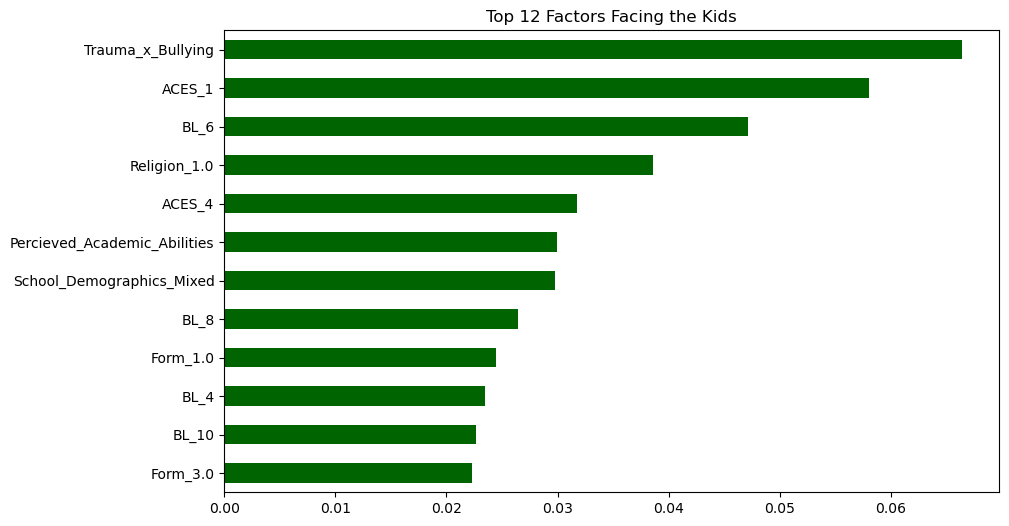

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Machine Learning imports
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 1. DATA LOADING & CLEANING
# Replace 'your_data.csv' with your actual file path
# df = pd.read_csv('your_data.csv') 

df_B = df[df["survey_number"] == "Survey B"].copy()

# Quality Control: Filter out unreliable responses using the GAD_Check
df_B = df_B[df_B['GAD_Check'] == 0]

# 2. TARGET ENGINEERING (The Binary Logic)
phq_cols = [f"PHQ_{i}" for i in range(1, 9)]
gad_cols = [f"GAD_{i}" for i in range(1, 8)]

# Calculate totals for the label only
df_B["PHQ_Total"] = df_B[phq_cols].fillna(0).sum(axis=1)
df_B["GAD_Total"] = df_B[gad_cols].fillna(0).sum(axis=1)

# 0 = Low Risk (Healthy)
# 1 = Needs Support (Moderate or High Risk)
df_B["Needs_Support"] = (df_B[["PHQ_Total", "GAD_Total"]].max(axis=1) > 4).astype(int)

# 3. FEATURE ENGINEERING
bl_individual_cols = [f"BL_{i}" for i in range(1, 11)]
ace_individual_cols = [f"ACES_{i}" for i in range(1, 11)]

# Impute survey questions with 0
all_q_cols = bl_individual_cols + ace_individual_cols
df_B[all_q_cols] = df_B[all_q_cols].fillna(0)

# Create interaction features
df_B["Bullying_Total"] = df_B[bl_individual_cols].sum(axis=1)
df_B["ACE_Total"] = df_B[ace_individual_cols].sum(axis=1)
df_B["Trauma_x_Bullying"] = df_B["ACE_Total"] * df_B["Bullying_Total"]

# Define final feature sets
numeric_features = [
    "Age", "Parents_Home", "Parents_Dead", "Fathers_Education", 
    "Mothers_Education", "Co_Curricular", "Percieved_Academic_Abilities",
    "Trauma_x_Bullying"
] + bl_individual_cols + ace_individual_cols

categorical_features = [
    "Gender", "Form", "Religion", "Boarding_day", 
    "School_type", "School_Demographics", "School_County", "Sports"
]

# 4. PREPROCESSING & IMPUTATION
X = df_B[numeric_features + categorical_features].copy()
y = df_B["Needs_Support"]

for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])

# 5. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. PIPELINE CONSTRUCTION
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

final_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=400,
        learning_rate=0.015,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# 7. TRAINING & EVALUATION
final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)

print(f"Final Binary Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Needs Support']))

# 8. VISUALIZATION: Top Predictors
ohe_names = list(final_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
all_features = numeric_features + ohe_names
importances = final_pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False).head(12)

plt.figure(figsize=(10,6))
feat_imp.plot(kind='barh', color='darkgreen')
plt.title("Top 12 Factors Facing the Kids")
plt.gca().invert_yaxis()
plt.show()

# 9. SAVE MODEL
# joblib.dump(final_pipeline, 'high_accuracy_mental_health_model.pkl')

In [13]:
import joblib
import json

# 1. Save the model pipeline (The .pkl replaces the .pth)
joblib.dump(final_pipeline, 'mental_health_model.pkl')

# 2. Save the feature lists so inference.py knows what to expect
features = {
    "numeric": numeric_features,
    "categorical": categorical_features
}
with open('features.json', 'w') as f:
    json.dump(features, f)

# 3. Save your analysis for the final report
feat_imp.to_csv('feature_importance.csv')
print("Notebook assets generated! You are ready to move to VS Code.")

Notebook assets generated! You are ready to move to VS Code.


<Figure size 800x600 with 0 Axes>

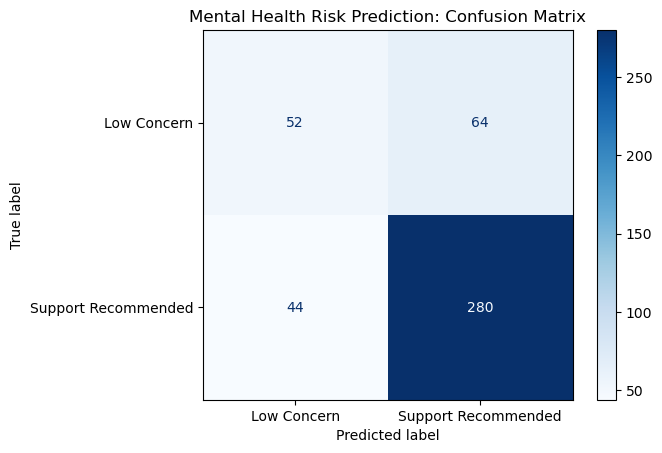

                     precision    recall  f1-score   support

        Low Concern       0.54      0.45      0.49       116
Support Recommended       0.81      0.86      0.84       324

           accuracy                           0.75       440
          macro avg       0.68      0.66      0.66       440
       weighted avg       0.74      0.75      0.75       440



In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Get predictions from your final pipeline
y_pred = final_pipeline.predict(X_test)

# 2. Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Plot the matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Concern', 'Support Recommended'])
disp.plot(cmap='Blues', values_format='d')

plt.title('Mental Health Risk Prediction: Confusion Matrix')
plt.show()

# 4. Print the text report for precision/recall
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Low Concern', 'Support Recommended']))

In [15]:
df_B.head()

,participant_ID,survey_number,Age,Gender,Form,Religion,Boarding_day,School_type,School_Demographics,School_County,...,HSB_10,HSB_11,HSB_12,HSB_13,PHQ_Total,GAD_Total,Needs_Support,Bullying_Total,ACE_Total,Trauma_x_Bullying
2845,B_3,Survey B,17.0,1.0,3.0,2.0,Day,Subcounty,Mixed,Kiambu,...,NaN,NaN,NaN,NaN,12.0,6.0,1,2.0,5.0,10.0
2847,B_5,Survey B,NaN,2.0,3.0,6.0,Boarding,Subcounty,Mixed,Kiambu,...,NaN,NaN,NaN,NaN,3.0,3.0,0,5.0,5.0,25.0
2848,B_6,Survey B,18.0,1.0,4.0,3.0,Day,Subcounty,Mixed,Nairobi,...,NaN,NaN,NaN,NaN,18.0,10.0,1,2.0,1.0,2.0
2849,B_7,Survey B,NaN,1.0,2.0,3.0,Day & Boarding,Subcounty,Mixed,Nairobi,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0.0,0.0,0.0
2850,B_8,Survey B,14.0,1.0,1.0,1.0,Boarding,Subcounty,Mixed,Kiambu,...,NaN,NaN,NaN,NaN,5.0,3.0,1,13.0,0.0,0.0


In [16]:
# Check the unique categories for the 3 "hidden" columns
hidden_columns = ['Boarding_day', 'School_type', 'School_Demographics']

for col in hidden_columns:
    if col in df.columns:
        print(f"--- Categories for {col} ---")
        print(df[col].unique())
        print("\n")
    else:
        print(f"Column '{col}' not found in the dataframe. Please check the spelling.")

--- Categories for Boarding_day ---
['Day & Boarding' 'Day' 'Boarding']


--- Categories for School_type ---
['Subcounty' 'Extracounty' 'County']


--- Categories for School_Demographics ---
['Mixed' 'Girls' 'Boys']


